lambdae_cpp=6.4878620732485315, ntokens_cpp=14
speedup_cpp=13.240534843364351
confFinal_cpp=['001', 'C']
cP_cpp=6, cS_cpp=2
lambdae_sycl=9.013754393741614, ntokens_sycl=8
speedup_sycl=18.395417130084926
confFinal_sycl=['001', 'C']
cP_sycl=1, cS_sycl=0
lambdae_avx=18.904615384615386, ntokens_avx=14
speedup_avx=38.58084772370487
confFinal_avx=['100', 'E']
cP_avx=7, cS_avx=0
lambdae_simd=19.622690830348187, ntokens_simd=13
speedup_simd=40.04630781703712
confFinal_simd=['010', 'G']
cP_simd=8, cS_simd=0


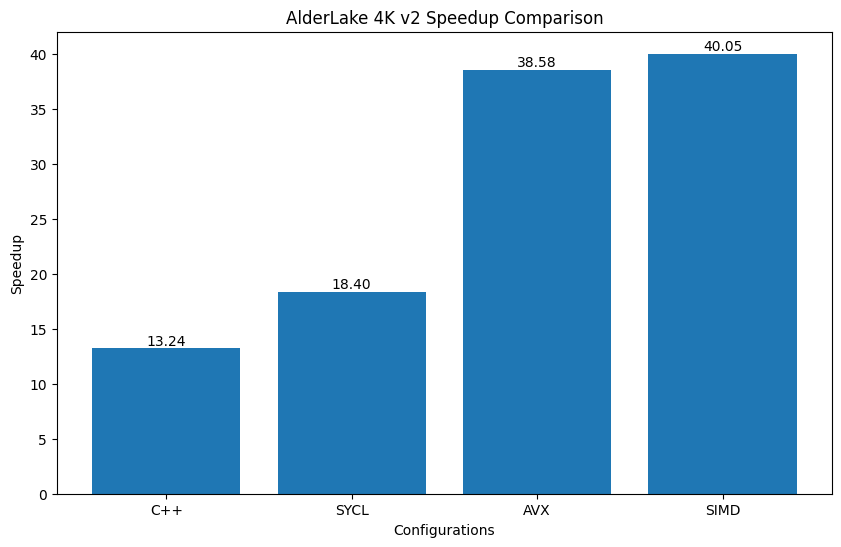

In [139]:
import numpy as np
DEBUG = False

def tiempom_espera5(llegada, activo, nstream, nterm):
    p0 = 0
    z = activo / llegada
    f = []
    fp = []
    pn = []
    p1 = []

    f0 = nterm * activo / llegada
    for i in range(nterm):
        if i <= nstream - 1:
            f.append((nterm - i) * activo / (llegada * (i + 1)))
        else:
            f.append((nterm - i) * activo / (llegada * nstream))

    for i in range(1, nterm + 1):
        vect = np.prod(f[:i])
        fp.append(vect)

    p0 = 1 / (1 + sum(fp))

    for i in range(1, nterm + 1):
        vect = np.prod(f[:i])
        pn.append(vect * p0)

    prob_ocupado = sum(pn[nstream - 1:])

    for i in range(nterm):
        p1.append((i + 1) * pn[i])

    L = sum(p1)
    Lq = max(0, L - (z * (nterm - L)))
    Wq = (Lq * llegada) / (nterm - L)
    tasa = (nterm - L) / llegada
    ro = tasa * activo / nstream

    # Debug: Check intermediate values
    if DEBUG:
        print(f"tiempom_espera5: llegada={llegada}, activo={activo}, nstream={nstream}, nterm={nterm}")
        print(f"f0={f0}, f={f}, fp={fp}, p0={p0}, pn={pn}")
        print(f"L={L}, Lq={Lq}, Wq={Wq}, tasa={tasa}, ro={ro}")

    return Lq, Wq, tasa, prob_ocupado, ro

def findOptConfP(nstages, thC, thG, nc):
    confP = ['0'] * nstages
    botlC, stC = min((val, idx) for (idx, val) in enumerate(thC))
    botlG, stG = min((val, idx) for (idx, val) in enumerate(thG))
    
    if botlC < botlG:
        confP[stC] = '1'
        stageBotl = stC
    else:
        confP[stG] = '0'
        stageBotl = stG

    TserCP = np.zeros(2**nstages - 1)
    TserGP = np.zeros(2**nstages - 1)
    TserCS = np.zeros(2**nstages - 1)
    TserGS = np.zeros(2**nstages - 1)

    p = np.ones(2**nstages - 1)
    Sdev = -np.ones(2**nstages - 1)
    rhoG = np.ones(2**nstages - 1)
    rhoC = np.ones(2**nstages - 1)
    lambda_vals = np.zeros(2**nstages - 1)

    for i in range(2**nstages - 1):
        if i == 2**nstages - 1:
            for k in range(nstages):
                TserGP[i] += 1 / thG[k]
                TserCP[i] += 1 / (thC[k] / nc)
            lambda_vals[i] = 1 / TserGP[i] + (1 / TserCP[i]) * nc
        else:
            conf = bin(i)[2:].zfill(nstages)
            if conf[stageBotl] == confP[stageBotl]:
                for k in range(nstages):
                    if conf[k] == '1':
                        TserGP[i] += 1 / thG[k]
                        TserCS[i] += 1 / (thC[k] / nc)
                    else:
                        TserCP[i] += 1 / (thC[k] / nc)
                        TserGS[i] += 1 / thG[k]
                if TserGP[i] == 0 or TserCP[i] == 0:
                    lambda_vals[i] = 0
                    continue
                
                lambdaGP = 1 / TserGP[i]
                lambdaCP = (1 / TserCP[i]) * nc
                lambdaG = lambdaGP
                lambdaC = lambdaCP

                # Imprimir valores intermedios
                if DEBUG:
                    print(f"Conf {i}: TserGP[i]={TserGP[i]}, TserCP[i]={TserCP[i]}")

                if lambdaGP < 0.9 * lambdaCP:
                    rhoC[i] = ((nc * TserGP[i] + TserCS[i]) / (TserGP[i] * TserCS[i])) * ((TserCP[i] * TserCS[i]) / (TserCP[i] + TserCS[i])) * (1 / nc)
                    cP = max(round(nc * rhoC[i]), 1)
                    cS = nc - cP
                    if rhoC[i] < 0.8:
                        Sdev[i] = 0
                        lambdaG = lambdaGP + ((1 / TserCS[i]) * nc) * (1 - rhoC[i])
                        lambdaC = lambdaCP * rhoC[i]
                        p[i] = lambdaGP / lambdaG
                else:
                    if lambdaCP < 0.9 * lambdaGP:
                        rhoG[i] = ((nc * TserGS[i] + TserCP[i]) / (TserGS[i] * TserCP[i])) * ((TserGP[i] * TserGS[i]) / (TserGP[i] + TserGS[i]))
                        if rhoG[i] < 0.8:
                            Sdev[i] = 1
                            lambdaG = lambdaGP * rhoG[i]
                            lambdaC = lambdaCP + (1 / TserGS[i]) * (1 - rhoG[i])
                            p[i] = lambdaCP / lambdaC
                
                lambda_vals[i] = min(lambdaG, lambdaC)
            else:
                lambda_vals[i] = 0

    lambdaOpt = max(lambda_vals)
    id_opt = np.argmax(lambda_vals)
    confOptP = bin(id_opt)[2:].zfill(nstages)
    confOptS = Sdev[id_opt]

    if DEBUG:
        print(f"Conf Opt: {confOptP}, Secondary Path: {confOptS}")

    romax = 0.95
    if id_opt == 2**nstages - 1:
        Tarrive = TserGP[id_opt]
    else:
        if confOptS == 0:
            Tarrive = 1 / (p[id_opt] * lambdaOpt)
        elif confOptS == 1:
            Tarrive = 1 / lambdaOpt
            romax = 0.95 * rhoG[id_opt]
        else:
            Tarrive = 1 / lambdaOpt
    
    TserG = TserGP[id_opt]
    c = 1
    NGP = 0
    roG = 0
    while roG < romax:
        NGP += 1
        LqG, WqG, lambdaeGP, prob_ocupadoG, roG = tiempom_espera5(Tarrive, TserG, c, NGP)
    if DEBUG:
        print(f"Primary GPU path: M/M/1/NGP/NGP with NGP= {NGP} and lambdaeGP= {lambdaeGP}")

    romax = 0.95
    if id_opt == 2**nstages - 1:
        Tarrive = TserCP[id_opt]
        cP = nc
    else:
        if confOptS == 0:
            Tarrive = 1 / lambdaOpt
            romax = 0.95 * rhoC[id_opt]
        elif confOptS == 1:
            Tarrive = 1 / (p[id_opt] * lambdaOpt)
        else:
            Tarrive = 1 / lambdaOpt
        cP = max(round(nc * rhoC[id_opt]), 1)

    TserC = TserCP[id_opt]
    c = nc
    NCP = 0
    roC = 0
    while roC < romax:
        NCP += 1
        LqC, WqC, lambdaeCP, prob_ocupadoC, roC = tiempom_espera5(Tarrive, TserC, c, NCP)
    if DEBUG:
        print(f"Primary CPU path: M/M/c/NCP/NCP with NCP= {NCP} and lambdaeCP= {lambdaeCP}")

    if confOptS == 1:
        Tarrive = 1 / ((1 - p[id_opt]) * lambdaOpt)
        romax = 0.95 * (1 - rhoG[id_opt])
        TserG = TserGS[id_opt]
        c = 1
        NGS = 0
        roG = 0
        while roG < romax:
            NGS += 1
            LqG, WqG, lambdaeGS, prob_ocupadoG, roG = tiempom_espera5(Tarrive, TserG, c, NGS)
        if DEBUG:
            print(f"Secondary GPU path: M/M/1/NGS/NGS with NGS= {NGS} and lambdaeGS= {lambdaeGS}")
    else:
        NGS = 0
        lambdaeGS = 0

    if confOptS == 0:
        Tarrive = 1 / ((1 - p[id_opt]) * lambdaOpt)
        romax = 0.95 * (1 - rhoC[id_opt])
        TserC = TserCS[id_opt]
        cS = nc - cP
        c = nc
        NCS = 0
        roC = 0
        while roC < romax:
            NCS += 1
            LqC, WqC, lambdaeCS, prob_ocupadoC, roC = tiempom_espera5(Tarrive, TserC, c, NCS)
        if DEBUG:
            print(f"Secondary CPU path: M/M/c/NCS/NCS with NCS= {NCS} and lambdaeCS= {lambdaeCS}")
    else:
        NCS = 0
        cS = 0
        lambdaeCS = 0

    if id_opt == 2**nstages - 1:
        lambdae = lambdaeGP + lambdaeCP
    else:
        lambdae = min(lambdaOpt, min(lambdaeGP + lambdaeCS, lambdaeCP + lambdaeGS))

    ntokens = NGP + NCP + NGS + NCS

    return lambdaOpt, confOptP, confOptS, lambdae, ntokens, cP, cS

import matplotlib.pyplot as plt

# Datos de entrada
thserial = 0.49
thC_cpp = [9, 465.7, 2.7]
thG_cpp = [19.2, 478, 5.9]
thC_sycl = [28.9, 1893, 4.6]
thG_sycl = [19.2, 478, 5.9]
thC_avx = [19.1, 670, 24.6]
thG_avx = [19.2, 478, 5.9]
thC_simd = [44.6, 661.1, 25.3]
thG_simd = [19.2, 478, 5.9]

nstages = len(thC_cpp)
nc = 8

# C++ Computation
lambdaOpt_cpp, confOptP_cpp, confS_cpp, lambdae_cpp, ntokens_cpp, cP_cpp, cS_cpp = findOptConfP(nstages, thC_cpp, thG_cpp, nc)
speedup_cpp = lambdae_cpp / thserial
SP_cpp = 'C' if confS_cpp == 0 else ('G' if confS_cpp == 1 else 'E')
confFinal_cpp = [confOptP_cpp, SP_cpp]
print(f"{lambdae_cpp=}, {ntokens_cpp=}")
print(f"{speedup_cpp=}")
print(f"{confFinal_cpp=}")
print(f"{cP_cpp=}, {cS_cpp=}")

# SYCL Computation
nc_sycl = 1
lambdaOpt_sycl, confOptP_sycl, confS_sycl, lambdae_sycl, ntokens_sycl, cP_sycl, cS_sycl = findOptConfP(nstages, thC_sycl, thG_sycl, nc_sycl)
speedup_sycl = lambdae_sycl / thserial
SP_sycl = 'C' if confS_sycl == 0 else ('G' if confS_sycl == 1 else 'E')
confFinal_sycl = [confOptP_sycl, SP_sycl]
print(f"{lambdae_sycl=}, {ntokens_sycl=}")
print(f"{speedup_sycl=}")
print(f"{confFinal_sycl=}")
print(f"{cP_sycl=}, {cS_sycl=}")

# AVX Computation
lambdaOpt_avx, confOptP_avx, confS_avx, lambdae_avx, ntokens_avx, cP_avx, cS_avx = findOptConfP(nstages, thC_avx, thG_avx, nc)
speedup_avx = lambdae_avx / thserial if lambdae_avx > 0 else 0
SP_avx = 'C' if confS_avx == 0 else ('G' if confS_avx == 1 else 'E')
confFinal_avx = [confOptP_avx, SP_avx]
print(f"{lambdae_avx=}, {ntokens_avx=}")
print(f"{speedup_avx=}")
print(f"{confFinal_avx=}")
print(f"{cP_avx=}, {cS_avx=}")

# SIMD Computation
lambdaOpt_simd, confOptP_simd, confS_simd, lambdae_simd, ntokens_simd, cP_simd, cS_simd = findOptConfP(nstages, thC_simd, thG_simd, nc)
speedup_simd = lambdae_simd / thserial if lambdae_simd > 0 else 0
SP_simd = 'C' if confS_simd == 0 else ('G' if confS_simd == 1 else 'E')
confFinal_simd = [confOptP_simd, SP_simd]
print(f"{lambdae_simd=}, {ntokens_simd=}")
print(f"{speedup_simd=}")
print(f"{confFinal_simd=}")
print(f"{cP_simd=}, {cS_simd=}")

# Plotting
speedups = [speedup_cpp, speedup_sycl, speedup_avx, speedup_simd]
x_labels = ['C++', 'SYCL', 'AVX', 'SIMD']

plt.figure(figsize=(10, 6))
x = np.arange(len(x_labels))
plt.bar(x, speedups)
plt.xticks(x, x_labels)
plt.xlabel('Configurations')
plt.ylabel('Speedup')
for i, v in enumerate(speedups):
    if np.isfinite(v):
        plt.text(x[i], v, f"{v:.2f}", ha='center', va='bottom')
plt.title('AlderLake 4K v2 Speedup Comparison')
plt.show()


In [140]:
import numpy as np
DEBUG = False

def tiempom_espera5(llegada, activo, nstream, nterm):
    p0 = 0
    z = activo / llegada
    f = []
    fp = []
    pn = []
    p1 = []

    f0 = nterm * activo / llegada
    for i in range(nterm):
        if i <= nstream - 1:
            f.append((nterm - i) * activo / (llegada * (i + 1)))
        else:
            f.append((nterm - i) * activo / (llegada * nstream))

    for i in range(1, nterm + 1):
        vect = np.prod(f[:i])
        fp.append(vect)

    p0 = 1 / (1 + sum(fp))

    for i in range(1, nterm + 1):
        vect = np.prod(f[:i])
        pn.append(vect * p0)

    prob_ocupado = sum(pn[nstream - 1:])

    for i in range(nterm):
        p1.append((i + 1) * pn[i])

    L = sum(p1)
    Lq = max(0, L - (z * (nterm - L)))
    Wq = (Lq * llegada) / (nterm - L)
    tasa = (nterm - L) / llegada
    ro = tasa * activo / nstream

    # # Debug: Check intermediate values
    # if DEBUG:
    #     print(f"tiempom_espera5: llegada={llegada}, activo={activo}, nstream={nstream}, nterm={nterm}")
    #     print(f"f0={f0}, f={f}, fp={fp}, p0={p0}, pn={pn}")
    #     print(f"L={L}, Lq={Lq}, Wq={Wq}, tasa={tasa}, ro={ro}")

    return Lq, Wq, tasa, prob_ocupado, ro

def findOptConfP(nstages, thC, thG, nc):
    confP = ['0'] * nstages
    botlC, stC = min((val, idx) for (idx, val) in enumerate(thC))
    botlG, stG = min((val, idx) for (idx, val) in enumerate(thG))
    
    if botlC < botlG:
        confP[stC] = '1'
        stageBotl = stC
        bottleneck_device = 'CPU'
    else:
        confP[stG] = '0'
        stageBotl = stG
        bottleneck_device = 'GPU'
        
    # Encuentra la mediana de los throughputs para el dispositivo bottleneck
    if bottleneck_device == 'CPU':
        mediana = np.median(thC)
        rango = [mediana * 0.25, mediana * 5]
        th_filtered = [val for val in thC if rango[0] <= val <= rango[1]]
        
        # Si todos los valores están fuera del rango, no filtrar
        if not th_filtered:
            th_filtered = thC
        
        best_stage = np.argmax(th_filtered) if th_filtered else np.argmax(thC)
    else:
        mediana = np.median(thG)
        rango = [mediana * 0.25, mediana * 5]
        th_filtered = [val for val in thG if rango[0] <= val <= rango[1]]
        
        # Si todos los valores están fuera del rango, no filtrar
        if not th_filtered:
            th_filtered = thG
        
        best_stage = np.argmax(th_filtered) if th_filtered else np.argmax(thG)

    TserCP = np.zeros(2**nstages)
    TserGP = np.zeros(2**nstages)
    TserCS = np.zeros(2**nstages)
    TserGS = np.zeros(2**nstages)

    p = np.ones(2**nstages)
    Sdev = -np.ones(2**nstages)
    rhoG = np.ones(2**nstages)
    rhoC = np.ones(2**nstages)
    lambda_vals = np.zeros(2**nstages)

    for i in range(1, 2**nstages):
        if i == 2**nstages - 1:
            # Decoupled path
            for k in range(nstages):
                TserGP[i] += 1 / thG[k]
                TserCP[i] += 1 / (thC[k] / nc)
            lambda_vals[i] = 1 / TserGP[i] + (1 / TserCP[i]) * nc
        else:
            # Coupled path
            conf = bin(i)[2:].zfill(nstages)
            # Prioriza la asignación del dispositivo bottleneck a la etapa con mejor throughput razonable
            if conf[stageBotl] == confP[stageBotl]:
                if bottleneck_device == 'CPU' and conf[best_stage] == '1':
                    lambda_vals[i] = 0
                    continue
                if bottleneck_device == 'GPU' and conf[best_stage] == '0':
                    lambda_vals[i] = 0
                    continue
                for k in range(nstages):
                    if conf[k] == '1':
                        TserGP[i] += 1 / thG[k]
                        TserCS[i] += 1 / (thC[k] / nc)
                    else:
                        TserCP[i] += 1 / (thC[k] / nc)
                        TserGS[i] += 1 / thG[k]
                if TserGP[i] == 0 or TserCP[i] == 0:
                    lambda_vals[i] = 0
                    continue
                
                lambdaGP = 1 / TserGP[i]
                lambdaCP = (1 / TserCP[i]) * nc
                lambdaG = lambdaGP
                lambdaC = lambdaCP

                # Imprimir valores intermedios
                if DEBUG:
                    print(f"Conf {i}: TserGP[i]={TserGP[i]}, TserCP[i]={TserCP[i]}")

                if lambdaGP < 0.9 * lambdaCP:
                    rhoC[i] = ((nc * TserGP[i] + TserCS[i]) / (TserGP[i] * TserCS[i])) * ((TserCP[i] * TserCS[i]) / (TserCP[i] + TserCS[i])) * (1 / nc)
                    cP = max(round(nc * rhoC[i]), 1)
                    cS = nc - cP
                    if rhoC[i] < 0.8:
                        Sdev[i] = 0
                        lambdaG = lambdaGP + ((1 / TserCS[i]) * nc) * (1 - rhoC[i])
                        lambdaC = lambdaCP * rhoC[i]
                        p[i] = lambdaGP / lambdaG
                else:
                    if lambdaCP < 0.9 * lambdaGP:
                        rhoG[i] = ((nc * TserGS[i] + TserCP[i]) / (TserGS[i] * TserCP[i])) * ((TserGP[i] * TserGS[i]) / (TserGP[i] + TserGS[i]))
                        if rhoG[i] < 0.8:
                            Sdev[i] = 1
                            lambdaG = lambdaGP * rhoG[i]
                            lambdaC = lambdaCP + (1 / TserGS[i]) * (1 - rhoG[i])
                            p[i] = lambdaCP / lambdaC
                
                lambda_vals[i] = min(lambdaG, lambdaC)
            else:
                # print(f"Conf {i}: {conf} not feasible")
                lambda_vals[i] = 0

    lambdaOpt = max(lambda_vals)
    id_opt = np.argmax(lambda_vals)
    confOptP = bin(id_opt)[2:].zfill(nstages)
    confOptS = Sdev[id_opt]

    if DEBUG:
        print(f"Conf Opt: {confOptP}, Secondary Path: {confOptS}")

    romax = 0.95
    if id_opt == 2**nstages - 1:
        Tarrive = TserGP[id_opt]
    else:
        if confOptS == 0:
            Tarrive = 1 / (p[id_opt] * lambdaOpt)
        elif confOptS == 1:
            Tarrive = 1 / lambdaOpt
            romax = 0.95 * rhoG[id_opt]
        else:
            Tarrive = 1 / lambdaOpt
    
    TserG = TserGP[id_opt]
    c = 1
    NGP = 0
    roG = 0
    while roG < romax:
        NGP += 1
        LqG, WqG, lambdaeGP, prob_ocupadoG, roG = tiempom_espera5(Tarrive, TserG, c, NGP)
    print(f"Primary GPU path: M/M/1/NGP/NGP with NGP= {NGP} and lambdaeGP= {lambdaeGP}")

    romax = 0.95
    if id_opt == 2**nstages - 1:
        Tarrive = TserCP[id_opt]
        cP = nc
    else:
        if confOptS == 0:
            Tarrive = 1 / lambdaOpt
            romax = 0.95 * rhoC[id_opt]
        elif confOptS == 1:
            Tarrive = 1 / (p[id_opt] * lambdaOpt)
        else:
            Tarrive = 1 / lambdaOpt
        cP = max(round(nc * rhoC[id_opt]), 1)

    TserC = TserCP[id_opt]
    c = nc
    NCP = 0
    roC = 0
    while roC < romax:
        NCP += 1
        LqC, WqC, lambdaeCP, prob_ocupadoC, roC = tiempom_espera5(Tarrive, TserC, c, NCP)
    print(f"Primary CPU path: M/M/c/NCP/NCP with NCP= {NCP} and lambdaeCP= {lambdaeCP}")

    if confOptS == 1:
        Tarrive = 1 / ((1 - p[id_opt]) * lambdaOpt)
        romax = 0.95 * (1 - rhoG[id_opt])
        TserG = TserGS[id_opt]
        c = 1
        NGS = 0
        roG = 0
        while roG < romax:
            NGS += 1
            LqG, WqG, lambdaeGS, prob_ocupadoG, roG = tiempom_espera5(Tarrive, TserG, c, NGS)
        print(f"Secondary GPU path: M/M/1/NGS/NGS with NGS= {NGS} and lambdaeGS= {lambdaeGS}")
    else:
        NGS = 0
        lambdaeGS = 0

    if confOptS == 0:
        Tarrive = 1 / ((1 - p[id_opt]) * lambdaOpt)
        romax = 0.95 * (1 - rhoC[id_opt])
        TserC = TserCS[id_opt]
        cS = nc - cP
        c = nc
        NCS = 0
        roC = 0
        while roC < romax:
            NCS += 1
            LqC, WqC, lambdaeCS, prob_ocupadoC, roC = tiempom_espera5(Tarrive, TserC, c, NCS)
        print(f"Secondary CPU path: M/M/c/NCS/NCS with NCS= {NCS} and lambdaeCS= {lambdaeCS}")
    else:
        NCS = 0
        cS = 0
        lambdaeCS = 0

    if id_opt == 2**nstages - 1:
        lambdae = lambdaeGP + lambdaeCP
    else:
        lambdae = min(lambdaOpt, min(lambdaeGP + lambdaeCS, lambdaeCP + lambdaeGS))

    # Si confOptP tiene un 1 en todas las etapas
    if confOptP == '1' * nstages:
        ntokens = nc + 1
    else:
        ntokens = NGP + NCP + NGS + NCS

    return lambdaOpt, confOptP, confOptS, lambdae, ntokens, cP, cS

C++ Computation
Primary GPU path: M/M/1/NGP/NGP with NGP= 4 and lambdaeGP= 5.80923076923077
Primary CPU path: M/M/c/NCP/NCP with NCP= 7 and lambdaeCP= 6.616855766822656
Secondary CPU path: M/M/c/NCS/NCS with NCS= 3 and lambdaeCS= 0.6786313040177615
lambdae_cpp=6.4878620732485315, ntokens_cpp=14
speedup_cpp=13.240534843364351
confFinal_cpp=['001', 'C']
cP_cpp=6, cS_cpp=2


SYCL Computation
Primary GPU path: M/M/1/NGP/NGP with NGP= 4 and lambdaeGP= 5.80923076923077
Primary CPU path: M/M/c/NCP/NCP with NCP= 2 and lambdaeCP= 12.967993026021194
Secondary CPU path: M/M/c/NCS/NCS with NCS= 2 and lambdaeCS= 3.204523624510843
lambdae_sycl=9.013754393741614, ntokens_sycl=8
speedup_sycl=18.395417130084926
confFinal_sycl=['001', 'C']
cP_sycl=1, cS_sycl=0


AVX Computation
Primary GPU path: M/M/1/NGP/NGP with NGP= 4 and lambdaeGP= 18.904615384615386
Primary CPU path: M/M/c/NCP/NCP with NCP= 10 and lambdaeCP= 23.25909927672608
lambdae_avx=18.904615384615386, ntokens_avx=14
speedup_avx=38.58084772370

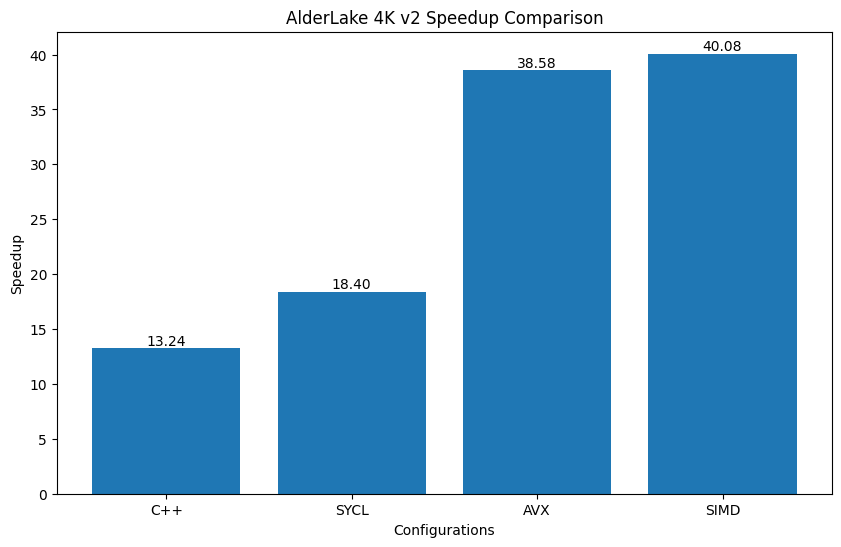

In [141]:
import matplotlib.pyplot as plt

# Datos de entrada
thserial = 0.49
thC_cpp = [9, 465.7, 2.7]
thG_cpp = [19.2, 478, 5.9]
thC_sycl = [28.9, 1893, 4.6]
thG_sycl = [19.2, 478, 5.9]
thC_avx = [19.1, 670, 24.6]
thG_avx = [19.2, 478, 5.9]
thC_simd = [44.6, 661.1, 25.3]
thG_simd = [19.2, 478, 5.9]

nstages = len(thC_cpp)
nc = 8

# C++ Computation
print("C++ Computation")
lambdaOpt_cpp, confOptP_cpp, confS_cpp, lambdae_cpp, ntokens_cpp, cP_cpp, cS_cpp = findOptConfP(nstages, thC_cpp, thG_cpp, nc)
speedup_cpp = lambdae_cpp / thserial
SP_cpp = 'C' if confS_cpp == 0 else ('G' if confS_cpp == 1 else 'E')
confFinal_cpp = [confOptP_cpp, SP_cpp]
print(f"{lambdae_cpp=}, {ntokens_cpp=}")
print(f"{speedup_cpp=}")
print(f"{confFinal_cpp=}")
print(f"{cP_cpp=}, {cS_cpp=}\n\n")

# SYCL Computation
print("SYCL Computation")
nc_sycl = 1
lambdaOpt_sycl, confOptP_sycl, confS_sycl, lambdae_sycl, ntokens_sycl, cP_sycl, cS_sycl = findOptConfP(nstages, thC_sycl, thG_sycl, nc_sycl)
speedup_sycl = lambdae_sycl / thserial
SP_sycl = 'C' if confS_sycl == 0 else ('G' if confS_sycl == 1 else 'E')
confFinal_sycl = [confOptP_sycl, SP_sycl]
print(f"{lambdae_sycl=}, {ntokens_sycl=}")
print(f"{speedup_sycl=}")
print(f"{confFinal_sycl=}")
print(f"{cP_sycl=}, {cS_sycl=}\n\n")

# AVX Computation
print("AVX Computation")
lambdaOpt_avx, confOptP_avx, confS_avx, lambdae_avx, ntokens_avx, cP_avx, cS_avx = findOptConfP(nstages, thC_avx, thG_avx, nc)
speedup_avx = lambdae_avx / thserial if lambdae_avx > 0 else 0
SP_avx = 'C' if confS_avx == 0 else ('G' if confS_avx == 1 else 'E')
confFinal_avx = [confOptP_avx, SP_avx]
print(f"{lambdae_avx=}, {ntokens_avx=}")
print(f"{speedup_avx=}")
print(f"{confFinal_avx=}")
print(f"{cP_avx=}, {cS_avx=}\n\n")

# SIMD Computation
print("SIMD Computation")
lambdaOpt_simd, confOptP_simd, confS_simd, lambdae_simd, ntokens_simd, cP_simd, cS_simd = findOptConfP(nstages, thC_simd, thG_simd, nc)
speedup_simd = lambdae_simd / thserial if lambdae_simd > 0 else 0
SP_simd = 'C' if confS_simd == 0 else ('G' if confS_simd == 1 else 'E')
confFinal_simd = [confOptP_simd, SP_simd]
print(f"{lambdae_simd=}, {ntokens_simd=}")
print(f"{speedup_simd=}")
print(f"{confFinal_simd=}")
print(f"{cP_simd=}, {cS_simd=}\n\n")

# Plotting
speedups = [speedup_cpp, speedup_sycl, speedup_avx, speedup_simd]
x_labels = ['C++', 'SYCL', 'AVX', 'SIMD']

plt.figure(figsize=(10, 6))
x = np.arange(len(x_labels))
plt.bar(x, speedups)
plt.xticks(x, x_labels)
plt.xlabel('Configurations')
plt.ylabel('Speedup')
for i, v in enumerate(speedups):
    if np.isfinite(v):
        plt.text(x[i], v, f"{v:.2f}", ha='center', va='bottom')
plt.title('AlderLake 4K v2 Speedup Comparison')
plt.show()


In [142]:
# Corner case computation
print("Extrem example: confP=001; GPU bottleneck and CPU can help")
thC=[10, 10,  9]
thG=[10,  10,  10]
lambdaOpt, confOptP, confS, lambdae, ntokens, cP, cS = findOptConfP(nstages, thC, thG, nc)
speedup = lambdae / thserial if lambdae > 0 else 0
SP = 'C' if confS == 0 else ('G' if confS == 1 else 'E')
confFinal = [confOptP, SP]
print(f"{lambdae=}, {ntokens=}")
print(f"{speedup=}")
print(f"{confFinal=}")
print(f"{cP=}, {cS=}\n\n")

print("Extrem example: confP=010")
thC=[10, 6, 14]
thG=[7, 12, 10]
lambdaOpt, confOptP, confS, lambdae, ntokens, cP, cS = findOptConfP(nstages, thC, thG, nc)
speedup = lambdae / thserial if lambdae > 0 else 0
SP = 'C' if confS == 0 else ('G' if confS == 1 else 'E')
confFinal = [confOptP, SP]
print(f"{lambdae=}, {ntokens=}")
print(f"{speedup=}")
print(f"{confFinal=}")
print(f"{cP=}, {cS=}\n\n")

print("Extrem example: confP=011")
thC=[10, 9,  9]
thG=[10,  10,  10]
lambdaOpt, confOptP, confS, lambdae, ntokens, cP, cS = findOptConfP(nstages, thC, thG, nc)
speedup = lambdae / thserial if lambdae > 0 else 0
SP = 'C' if confS == 0 else ('G' if confS == 1 else 'E')
confFinal = [confOptP, SP]
print(f"{lambdae=}, {ntokens=}")
print(f"{speedup=}")
print(f"{confFinal=}")
print(f"{cP=}, {cS=}\n\n")

print("Extrem example: confP=100; CPU bottleneck and GPU can help")
thC=[10, 12, 10]
thG=[10, 10, 9]
lambdaOpt, confOptP, confS, lambdae, ntokens, cP, cS = findOptConfP(nstages, thC, thG, nc)
speedup = lambdae / thserial if lambdae > 0 else 0
SP = 'C' if confS == 0 else ('G' if confS == 1 else 'E')
confFinal = [confOptP, SP]
print(f"{lambdae=}, {ntokens=}")
print(f"{speedup=}")
print(f"{confFinal=}")
print(f"{cP=}, {cS=}\n\n")

print("Extrem example: confP=110; GPU bottleneck and CPU can help")
thC=[10, 10, 10]
thG=[10, 10, 9]
lambdaOpt, confOptP, confS, lambdae, ntokens, cP, cS = findOptConfP(nstages, thC, thG, nc)
speedup = lambdae / thserial if lambdae > 0 else 0
SP = 'C' if confS == 0 else ('G' if confS == 1 else 'E')
confFinal = [confOptP, SP]
print(f"{lambdae=}, {ntokens=}")
print(f"{speedup=}")
print(f"{confFinal=}")
print(f"{cP=}, {cS=}\n\n")

print("Extrem example: confP=111")
thC=[9, 9, 9]
thG=[12, 12, 12]
lambdaOpt, confOptP, confS, lambdae, ntokens, cP, cS = findOptConfP(nstages, thC, thG, nc)
speedup = lambdae / thserial if lambdae > 0 else 0
SP = 'C' if confS == 0 else ('G' if confS == 1 else 'E')
confFinal = [confOptP, SP]
print(f"{lambdae=}, {ntokens=}")
print(f"{speedup=}")
print(f"{confFinal=}")
print(f"{cP=}, {cS=}\n\n")

print("Extrem example: confP=111")
thC=[12, 12, 12]
thG=[9, 9, 9]
lambdaOpt, confOptP, confS, lambdae, ntokens, cP, cS = findOptConfP(nstages, thC, thG, nc)
speedup = lambdae / thserial if lambdae > 0 else 0
SP = 'C' if confS == 0 else ('G' if confS == 1 else 'E')
confFinal = [confOptP, SP]
print(f"{lambdae=}, {ntokens=}")
print(f"{speedup=}")
print(f"{confFinal=}")
print(f"{cP=}, {cS=}\n\n")

Extrem example: confP=001; GPU bottleneck and CPU can help
Primary GPU path: M/M/1/NGP/NGP with NGP= 2 and lambdaeGP= 6.896551724137931
Primary CPU path: M/M/c/NCP/NCP with NCP= 9 and lambdaeCP= 4.792462750376075
Secondary GPU path: M/M/1/NGS/NGS with NGS= 2 and lambdaeGS= 2.3529411764705888
lambdae=6.666666666666665, ntokens=13
speedup=13.605442176870746
confFinal=['001', 'G']
cP=8, cS=0


Extrem example: confP=010
Primary GPU path: M/M/1/NGP/NGP with NGP= 2 and lambdaeGP= 7.996196780793695
Primary CPU path: M/M/c/NCP/NCP with NCP= 9 and lambdaeCP= 5.5912065421054225
Secondary GPU path: M/M/1/NGS/NGS with NGS= 2 and lambdaeGS= 2.116824908264222
lambdae=7.408759124087592, ntokens=13
speedup=15.119916579770596
confFinal=['010', 'G']
cP=8, cS=0


Extrem example: confP=011
Primary GPU path: M/M/1/NGP/NGP with NGP= 4 and lambdaeGP= 4.923076923076919
Primary CPU path: M/M/c/NCP/NCP with NCP= 6 and lambdaeCP= 6.298342541436467
Secondary CPU path: M/M/c/NCS/NCS with NCS= 4 and lambdaeCS= 1.65